# Read dataset

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Read dataset from directory
dir_data = './data/'
raw_data = os.path.join(dir_data, 'crx.data')
data = np.genfromtxt(raw_data, delimiter=",", dtype=str)
label = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']

# Put txt files into DataFrame

In [2]:
arrange_data = []
for line in data:
    arrange_data.append(line)
    
df = pd.DataFrame(arrange_data)
df.columns = label

# processing with missimg value
df.replace('?', inplace=True)  # replace missing value with previous value

df=df.astype({'A2':'float32',
              'A3':'float32',
              'A8':'float32'})
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.830000,0.000,u,g,w,v,1.25,t,t,01,f,g,00202,0,+
1,a,58.669998,4.460,u,g,q,h,3.04,t,t,06,f,g,00043,560,+
2,a,24.500000,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.830000,1.540,u,g,w,v,3.75,t,t,05,t,g,00100,3,+
4,b,20.170000,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


# Split training data & testing data

In [3]:
crx_data = df[['A1', 'A2', 'A3', 'A4', 'A5', 'A8', 'A15']]
crx_label = df['A16']
train_data , test_data , train_label , test_label = train_test_split(crx_data, crx_label, test_size=0.33, stratify=crx_label)

# Convert dataframe into list
train_data = train_data.values.tolist()
train_label = train_label.values.tolist()
test_data = test_data.values.tolist()
test_label = test_label.values.tolist()

# KNN Algorithm(K = 5)
## Euclidean distance

In [4]:
# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return distance**0.5

# Locate the most similar neighbors
def get_neighbors(train_data, train_label, test_row, num_neighbors):
    distances = []
    for index in range(len(train_data)):
        dist = euclidean_distance(test_row, train_data[index])
        distances.append((train_data[index], dist, train_label[index]))
    distances.sort(key=lambda tup: tup[1])
    neighbors = []
    for i in range(num_neighbors):
        neighbors.append([distances[i][0], distances[i][-1]])
    return neighbors

# Make a prediction with neighbors
def predict_classification(train_data, train_label, test_row, num_neighbors):
    neighbors = get_neighbors(train_data, train_label, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

# kNN Algorithm
def k_nearest_neighbors(train_data, train_label, test_data, num_neighbors):
    predictions = []
    for row in test_data:
        output = predict_classification(train_data, train_label, row, num_neighbors)
        predictions.append(output)
    return predictions

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# convert columns to int
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
        # print('[%s] => %d' % (value, i))
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup        

# convert columns to float
for i in range(len(train_data[0])):
    if(isinstance(train_data[0][i], (str))):
        str_column_to_int(train_data, i)
        str_column_to_int(test_data, i)

# define model parameter
num_neighbors = 5

pred = k_nearest_neighbors(train_data, train_label, test_data, num_neighbors)
print("Accuracy: %.2f %%" % accuracy_metric(test_label, pred))
print("\nConfusion Matrix:")
print(confusion_matrix(test_label, pred))
print("\nClassification Report:")
print(classification_report(test_label, pred))

Accuracy: 67.11 %

Confusion Matrix:
[[64 37]
 [38 89]]

Classification Report:
              precision    recall  f1-score   support

           +       0.63      0.63      0.63       101
           -       0.71      0.70      0.70       127

   micro avg       0.67      0.67      0.67       228
   macro avg       0.67      0.67      0.67       228
weighted avg       0.67      0.67      0.67       228



### Compare the accuracy with different values of K (Euclidean distance)

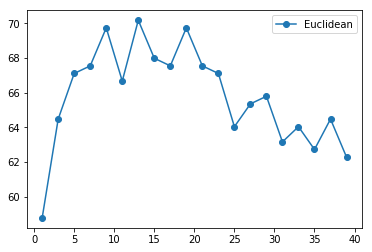

In [5]:
K_accuracy_euclidean = []
for values in range(1, 41, 2):
    pred = k_nearest_neighbors(train_data, train_label, test_data, values)
    K_accuracy_euclidean.append(accuracy_metric(test_label, pred))
plt.plot(range(1, 41, 2), K_accuracy_euclidean, label="Euclidean", marker='o')
plt.legend()
plt.show()

## Chebyshev distance

In [6]:
# Calculate the Chebyshev distance between two vectors
def chebyshev_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += np.max(np.abs(row1[i] - row2[i]))
    return distance

# Locate the most similar neighbors
def get_neighbors(train_data, train_label, test_row, num_neighbors):
    distances = []
    for index in range(len(train_data)):
        dist = chebyshev_distance(test_row, train_data[index])
        distances.append((train_data[index], dist, train_label[index]))
    distances.sort(key=lambda tup: tup[1])
    neighbors = []
    for i in range(num_neighbors):
        neighbors.append([distances[i][0], distances[i][-1]])
    return neighbors

# Make a prediction with neighbors
def predict_classification(train_data, train_label, test_row, num_neighbors):
    neighbors = get_neighbors(train_data, train_label, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

# kNN Algorithm
def k_nearest_neighbors(train_data, train_label, test_data, num_neighbors):
    predictions = []
    for row in test_data:
        output = predict_classification(train_data, train_label, row, num_neighbors)
        predictions.append(output)
    return predictions

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# define model parameter
num_neighbors = 5

pred = k_nearest_neighbors(train_data, train_label, test_data, num_neighbors)
print("Accuracy: %.2f %%" % accuracy_metric(test_label, pred))
print("\nConfusion Matrix:")
print(confusion_matrix(test_label, pred))
print("\nClassification Report:")
print(classification_report(test_label, pred))

Accuracy: 65.79 %

Confusion Matrix:
[[58 43]
 [35 92]]

Classification Report:
              precision    recall  f1-score   support

           +       0.62      0.57      0.60       101
           -       0.68      0.72      0.70       127

   micro avg       0.66      0.66      0.66       228
   macro avg       0.65      0.65      0.65       228
weighted avg       0.66      0.66      0.66       228



### Compare the accuracy with different values of K (Chebyshev distance)

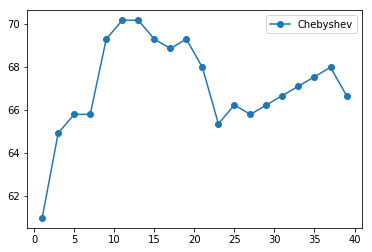

In [7]:
K_accuracy_chebyshev = []
for values in range(1, 41, 2):
    pred = k_nearest_neighbors(train_data, train_label, test_data, values)
    K_accuracy_chebyshev.append(accuracy_metric(test_label, pred))
plt.plot(range(1, 41, 2), K_accuracy_chebyshev, label="Chebyshev", marker='o')
plt.legend()
plt.show()

## Jaccard similarity

In [8]:
# Calculate the Jaccard similarity between two vectors
def jaccard_similarity(row1, row2):
    s1 = set(row1)
    s2 = set(row2)
    return 1 - (len(s1.intersection(s2)) / len(s1.union(s2)))

# Locate the most similar neighbors
def get_neighbors(train_data, train_label, test_row, num_neighbors):
    distances = []
    for index in range(len(train_data)):
        dist = jaccard_similarity(test_row, train_data[index])
        distances.append((train_data[index], dist, train_label[index]))
    distances.sort(key=lambda tup: tup[1])
    neighbors = []
    for i in range(num_neighbors):
        neighbors.append([distances[i][0], distances[i][-1]])
    return neighbors

# Make a prediction with neighbors
def predict_classification(train_data, train_label, test_row, num_neighbors):
    neighbors = get_neighbors(train_data, train_label, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

# kNN Algorithm
def k_nearest_neighbors(train_data, train_label, test_data, num_neighbors):
    predictions = []
    for row in test_data:
        output = predict_classification(train_data, train_label, row, num_neighbors)
        predictions.append(output)
    return predictions

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# define model parameter
num_neighbors = 5

pred = k_nearest_neighbors(train_data, train_label, test_data, num_neighbors)
print("Accuracy: %.2f %%" % accuracy_metric(test_label, pred))
print("\nConfusion Matrix:")
print(confusion_matrix(test_label, pred))
print("\nClassification Report:")
print(classification_report(test_label, pred))

Accuracy: 59.21 %

Confusion Matrix:
[[42 59]
 [34 93]]

Classification Report:
              precision    recall  f1-score   support

           +       0.55      0.42      0.47       101
           -       0.61      0.73      0.67       127

   micro avg       0.59      0.59      0.59       228
   macro avg       0.58      0.57      0.57       228
weighted avg       0.59      0.59      0.58       228



### Compare the accuracy with different values of K (Jaccard similarity)

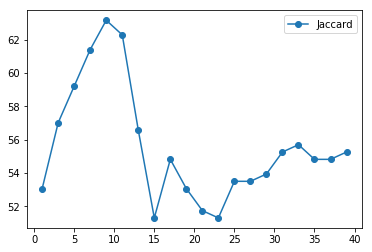

In [9]:
K_accuracy_jaccard = []
for values in range(1, 41, 2):
    pred = k_nearest_neighbors(train_data, train_label, test_data, values)
    K_accuracy_jaccard.append(accuracy_metric(test_label, pred))
plt.plot(range(1, 41, 2), K_accuracy_jaccard, label="Jaccard", marker='o')
plt.legend()
plt.show()

## Cosine similarity

In [10]:
# Calculate the Cosine similarity between two vectors
def cosine_similarity(row1, row2):
    dot = np.dot(row1, row2)
    norma = np.linalg.norm(row1)
    normb = np.linalg.norm(row2)
    return dot / (norma * normb)

# Locate the most similar neighbors
def get_neighbors(train_data, train_label, test_row, num_neighbors):
    distances = []
    for index in range(len(train_data)):
        dist = cosine_similarity(test_row, train_data[index])
        distances.append((train_data[index], dist, train_label[index]))
    distances.sort(key=lambda tup: tup[1], reverse=True)
    neighbors = []
    for i in range(num_neighbors):
        neighbors.append([distances[i][0], distances[i][-1]])
    return neighbors

# Make a prediction with neighbors
def predict_classification(train_data, train_label, test_row, num_neighbors):
    neighbors = get_neighbors(train_data, train_label, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

# kNN Algorithm
def k_nearest_neighbors(train_data, train_label, test_data, num_neighbors):
    predictions = []
    for row in test_data:
        output = predict_classification(train_data, train_label, row, num_neighbors)
        predictions.append(output)
    return predictions

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# define model parameter
num_neighbors = 5

pred = k_nearest_neighbors(train_data, train_label, test_data, num_neighbors)
print("Accuracy: %.2f %%" % accuracy_metric(test_label, pred))
print("\nConfusion Matrix:")
print(confusion_matrix(test_label, pred))
print("\nClassification Report:")
print(classification_report(test_label, pred))

Accuracy: 58.77 %

Confusion Matrix:
[[51 50]
 [44 83]]

Classification Report:
              precision    recall  f1-score   support

           +       0.54      0.50      0.52       101
           -       0.62      0.65      0.64       127

   micro avg       0.59      0.59      0.59       228
   macro avg       0.58      0.58      0.58       228
weighted avg       0.59      0.59      0.59       228



### Compare the accuracy with different values of K (Cosine similarity)

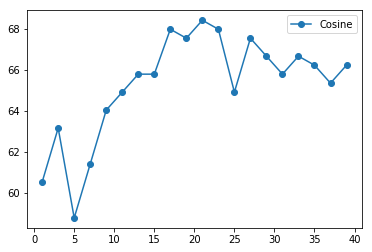

In [11]:
K_accuracy_cosine = []
for values in range(1, 41, 2):
    pred = k_nearest_neighbors(train_data, train_label, test_data, values)
    K_accuracy_cosine.append(accuracy_metric(test_label, pred))
plt.plot(range(1, 41, 2), K_accuracy_cosine, label="Cosine", marker='o')
plt.legend()
plt.show()

# Compare the accuracy with different  similarity function

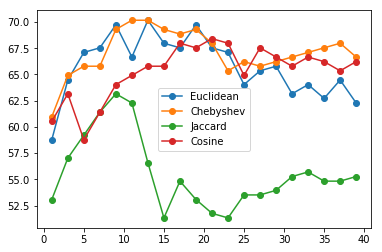

In [12]:
plt.plot(range(1, 41, 2), K_accuracy_euclidean, label="Euclidean", marker='o')
plt.plot(range(1, 41, 2), K_accuracy_chebyshev, label="Chebyshev", marker='o')
plt.plot(range(1, 41, 2), K_accuracy_jaccard, label="Jaccard", marker='o')
plt.plot(range(1, 41, 2), K_accuracy_cosine, label="Cosine", marker='o')
plt.legend()
plt.show()